# Tarea 2. Visión Computacional

Guillermo Segura Gómez

## Ejercicio 1

Follow the OpenCV calibration tutorial to perform the calibration of a camera of your choice
with the following chessboard pattern. Verify that the average reprojection error (i.e. the
average distance, in pixels, between the detected points and the projected points according to the estimated projection matrix) that you get are well below 1 pixel.
When the calibration is over, use the intrinsic and extrinsic parameters to project a 3D shape of your choice (e.g. a cube) on the diferent images of the chessboard.

---

Las propiedades intrínsecas y extrínsecas de una cámara son fundamentales para comprender cómo una cámara captura imágenes del mundo tridimensional y las proyecta en un plano bidimensional (el sensor de la cámara). Estas propiedades están estrechamente relacionadas con las transformaciones proyectivas en la geometría y la visión por computadora.

### Propiedades Intrínsecas:

Las propiedades intrínsecas de una cámara se refieren a las características internas de la cámara que afectan la formación de la imagen. No dependen de la posición ni de la orientación de la cámara en el espacio. Incluyen:

1. **Distancia Focal**: La distancia entre el centro óptico de la lente y el sensor de la cámara cuando un objeto está enfocado. Afecta el campo de visión de la cámara y la magnificación de la imagen.

2. **Punto Principal (o Centro Óptico)**: El punto en el sensor de la cámara donde el eje óptico intersecta el plano de la imagen.

3. **Coeficientes de Distorsión de la Lente**: Describen cómo la luz se desvía debido a la forma de la lente, lo que puede causar que las líneas rectas aparezcan curvas en la imagen.

La matriz intrínseca $A$ encapsula estas propiedades y se utiliza para convertir coordenadas de puntos 3D en el sistema de coordenadas de la cámara a coordenadas de puntos 2D en el plano de la imagen:

$$
A = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

donde $f_x$ y $f_y$ son las distancias focales expresadas en unidades de píxeles en las direcciones $x$ e $y$, respectivamente, y $(c_x, c_y)$ son las coordenadas del punto principal en el plano de la imagen.

### Propiedades Extrínsecas:

Las propiedades extrínsecas se relacionan con la posición y orientación de la cámara en el espacio mundial. Incluyen:

1. **Rotación**: La orientación de la cámara en relación con un sistema de coordenadas del mundo.

2. **Traslación**: La posición de la cámara en el espacio mundial.

Estas propiedades se representan mediante una matriz de rotación $R$ y un vector de traslación $t$, y se utilizan para transformar las coordenadas de los puntos 3D del mundo a las coordenadas del sistema de la cámara.

### Calibración de una cámara

La calibración de una cámara consiste en identificar los parámetros intrínsecos y extrínsecos dado un modelo geométrico de la cámara. Típicamente se utilizan diferentes vistas de la escena u objetos para identificar correspondencias y usar esas correspondencias para formar una función objetivo y optimizar. Para realizar esto vamos a utilizar la librería OpenCV que es muy utilizada en visión computacional. El objetivo es encontrar la matriz de la cámara que contiene los parámetros extrínsecos e intrínsecos, con los que podemos proyectar una forma en las imágenes del tablero de ajedrez.

Lo primero que tenemos que hacer es importar las librería necesarias. Tomé algunas fotos de distintos ángulos para poder hacer la calibración de mi propio tablero de ajedrez.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

In [53]:
# Criterios de terminación
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Preparar puntos objeto, como (0,0,0), (1,0,0), (2,0,0) ...., teniendo en cuenta que es un patrón 8x8 con 7x7 esquinas internas
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)  # Ajuste para 7x7 esquinas internas

# Arrays para almacenar puntos objeto y puntos imagen de todas las imágenes
objpoints = []  # Puntos 3D en el espacio del mundo real
imgpoints = []  # Puntos 2D en el plano de la imagen

# Leer imágenes
images = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 2/ChessPattern/*.jpg')

for fname in images:
    img = cv.imread(fname)

    # Convertimos a rgb la imagen
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Encontrar las esquinas del tablero de ajedrez
    ret, corners = cv.findChessboardCorners(img_rgb, (7,7), None)  # Ajuste para 7x7 esquinas internas

    # Si se encuentran, añadir puntos objeto, puntos imagen (después de refinarlos)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(img_rgb, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Dibujar y mostrar las esquinas
        cv.drawChessboardCorners(img, (7,7), corners2, ret)  # Asegúrate de usar la imagen a color 'img' para visualizar
        # cv.imshow('img', img)  # Muestra la imagen con las esquinas dibujadas
        cv.waitKey(500)  # Espera 500 ms entre imágenes

cv.destroyAllWindows()  # Cierra todas las ventanas


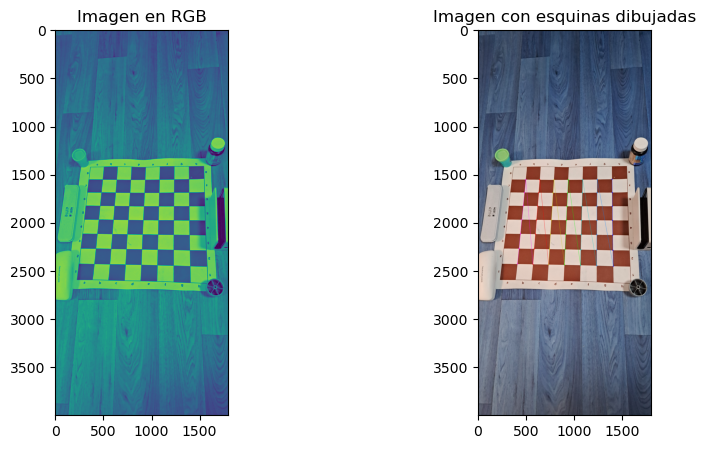

In [55]:
# Ejemplo imágnes
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Imagen en RGB')

plt.subplot(122)
plt.imshow(cv.drawChessboardCorners(img, (7,7), corners2, ret))
plt.title('Imagen con esquinas dibujadas')

plt.show()

Ahora, ya tenemos nuestros puntos del objeto y los puntos de la imagen. Ya podemos realizar la calibración. 
La función ```calibrateCamera()``` se utiliza para calcular los parámetros intrínsecos y extrínsecos de la cámara.

*    **retval** es un valor booleano que indica si la calibración fue exitosa.
*    **cameraMatrix** es la matriz de parámetros intrínsecos de la cámara.
*    **distCoeffs** son los coeficientes de distorsión.
*    **rvecs** y **tvecs** son las rotaciones y traslaciones para cada una de las imágenes del patrón de calibración.*

In [56]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_rgb.shape[::-1], None, None)

### Corrección de la distorsión de una imagen

In [57]:
# Selección de una imagen para demostrar la corrección de distorsión
img = cv.imread(images[2])  # Utilizamos una de las mismas imágenes

La función `undistort()` se utiliza para corregir la distorsión en la imagen usando los parámetros obtenidos de la calibración.

In [58]:
# Desdistorsión de la imagen
dst = cv.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)

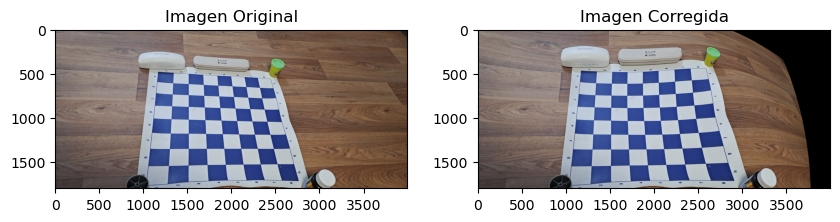

In [59]:
# Visualización de la imagen antes y después de la corrección de distorsión

# Convertir de BGR a RGB para visualización con matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
dst_rgb = cv.cvtColor(dst, cv.COLOR_BGR2RGB)

# Mostrar las imágenes
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Imagen Original')

plt.subplot(122)
plt.imshow(dst_rgb)
plt.title('Imagen Corregida')

plt.show()

### Error de reproyección

El error de reproyección se refiere a la diferencia, medida en píxeles, entre las esquinas detectadas en las imágenes (puntos de imagen) y las esquinas proyectadas utilizando los parámetros de calibración estimados. Calculamos el error como sigue:

In [60]:
# Calcular el error de reproyección total
total_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
    total_error += error

# Calcular el error de reproyección promedio
mean_error = total_error / len(objpoints)
print(f"Error de reproyección promedio: {mean_error} píxeles")


Error de reproyección promedio: 0.40804412884052654 píxeles


### Proyección de una imágen 

Una vez que la cámara está calibrada, podemos usar los parámetros intrínsecos y extrínsecos para proyectar una forma 3D, como un cubo, en las imágenes.

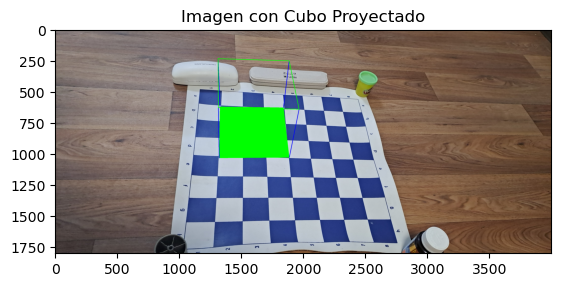

In [64]:
# Definir los puntos 3D del cubo (en este caso, un cubo con longitud de lado 3 unidades en el espacio del objeto)
puntos_cubo = np.float32([[0,0,0], [3,0,0], [3,3,0], [0,3,0],
                          [0,0,-3], [3,0,-3], [3,3,-3], [0,3,-3]])

# Elegir una imagen y los parámetros extrínsecos correspondientes
img = cv.imread(images[2])  
rvec, tvec = rvecs[2], tvecs[2]  # Usar los parámetros extrínsecos de la primera imagen

# Proyectar los puntos 3D del cubo al plano de la imagen
puntos_img, _ = cv.projectPoints(puntos_cubo, rvec, tvec, cameraMatrix, distCoeffs)

# Dibujar las líneas del cubo en la imagen
puntos_img = np.int32(puntos_img).reshape(-1,2)
img = cv.drawContours(img, [puntos_img[:4]], -1, (0,255,0), -3)  # Dibuja la base
for i,j in zip(range(4), range(4,8)):  # Dibuja los pilares
    img = cv.line(img, tuple(puntos_img[i]), tuple(puntos_img[j]), (255), 3)
img = cv.drawContours(img, [puntos_img[4:]], -1, (0,255,0), 3)  # Dibuja la tapa

# Mostrar la imagen con el cubo proyectado
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Imagen con Cubo Proyectado')
plt.show()


## Ejercicio 2

Implement a Python script or a C++ program that implements the algorithm decomposing a projection matrix P = [A, b], as described in the class. You will probe it with K, R, t values that  you will have chosen beforehand. Your algorithm should output both the intrinsic and the extrinsic
parameters.

We saw in the lecture that this decomposition could lead to two possible decompositions of the form:

$$
P \propto K [Rt]
$$

Give a geometric interpretation of what these two solutions may be.

---

Para implementar un script en Python que descomponga una matriz de proyección $P = [A | b]$ en sus parámetros intrínsecos y extrínsecos, se sigue el método discutido en clase, que se basa en la factorización RQ. Este método se utiliza para descomponer la parte izquierda $A$ de la matriz de proyección $P$ en una matriz de parámetros intrínsecos $K$ y una matriz de rotación $R$, mientras que el vector $b$ se relaciona con el vector de traslación $t$.

Este script define una función `decompose_projection_matrix()` que toma una matriz de proyección $P$ como entrada y devuelve la matriz intrínseca $K$, la matriz de rotación $R$, y el vector de traslación $t$. La descomposición se realiza utilizando una factorización RQ aplicada a la submatriz $A$ de $P$.

In [65]:
def decompose_projection_matrix(P):
    # Asegurarse de que P es 3x4
    assert P.shape == (3, 4)
    
    # Separar A y b de P
    A = P[:, :3]  # Matriz 3x3
    b = P[:, 3]   # Vector 3x1
    
    # Factorización RQ para obtener K y R
    K, R = np.linalg.qr(np.linalg.inv(A))
    
    # Ajustar K para que tenga la forma correcta, asegurando que los elementos diagonales sean positivos
    T = np.diag(np.sign(np.diag(K)))
    K = np.dot(K, T)
    R = np.dot(T, R)
    
    # Asegurar que la matriz K tiene el elemento (3, 3) igual a 1
    K /= K[2, 2]
    
    # Calcular el vector de traslación t
    t = np.linalg.inv(K).dot(b)
    
    return K, R, t

# Definir una matriz de proyección P como ejemplo
P = np.array([[300, 0, 100, 200],
              [0, 300, 150, 500],
              [0, 0, 1, 2]])

# Descomponer P
K, R, t = decompose_projection_matrix(P)

print("Matriz Intrínseca K:\n", K)
print("\nMatriz de Rotación R:\n", R)
print("\nVector de Traslación t:\n", t)


Matriz Intrínseca K:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Matriz de Rotación R:
 [[ 0.00333333  0.         -0.33333333]
 [ 0.          0.00333333 -0.5       ]
 [ 0.          0.          1.        ]]

Vector de Traslación t:
 [200. 500.   2.]


### Interpretación Geométrica de las Dos Posibles Descomposiciones

La descomposición de una matriz de proyección en términos de $P \propto K [R | t]$ puede llevar a dos soluciones posibles debido a la ambigüedad en la orientación de la cámara respecto al mundo 3D:

1. **Solución 1**: Corresponde a la configuración donde la cámara está frente al objeto y orientada de tal manera que el objeto está en la dirección de visualización positiva de la cámara. Esta es la configuración más común y natural para la captura de imágenes.

2. **Solución 2**: Representa una configuración donde la cámara está detrás del objeto y mirando en dirección opuesta, como si se estuviera viendo el objeto a través de un espejo. En este caso, la cámara y el objeto están en lados opuestos del plano de proyección, lo que da lugar a una imagen invertida.

## Ejercicio 3

Suppose you spot an interesting pixel of coordinates (u, v) in an image. Determine the equation of the 3D ray passing through this pixel and the optical center of the camera, in function of the intrinsic parameters matrix K.

---

Para determinar la ecuación del rayo 3D que pasa por un píxel de coordenadas $(u, v)$ en una imagen y por el centro óptico de la cámara, podemos usar la matriz de parámetros intrínsecos $K$ de la cámara. La matriz $K$ relaciona las coordenadas de un punto en el espacio de la cámara 3D $[X_c, Y_c, Z_c]$ con las coordenadas de un punto en el plano de la imagen $[u, v, 1]$ mediante la ecuación:

$$
\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = K \begin{bmatrix} X_c \\ Y_c \\ Z_c \end{bmatrix}
$$

donde $K$ es la matriz intrínseca de la cámara, definida como:

$$
K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
$$

Aquí, $f_x$ y $f_y$ son las distancias focales expresadas en unidades de píxeles en las direcciones $x$ e $y$ respectivamente, y $(c_x, c_y)$ son las coordenadas del punto principal en el plano de la imagen.

Para encontrar la ecuación del rayo 3D, necesitamos expresar las coordenadas del espacio de la cámara $[X_c, Y_c, Z_c]$ en función de las coordenadas del píxel $(u, v)$ y la matriz $K$. Podemos hacer esto invirtiendo la relación dada por la matriz $K$:

$$
\begin{bmatrix} X_c \\ Y_c \\ Z_c \end{bmatrix} = K^{-1} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
$$

La ecuación del rayo en el espacio 3D que pasa por el centro óptico de la cámara y el píxel $(u, v)$ se puede escribir como:

$$
\mathbf{r}(t) = t \cdot (K^{-1} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix})
$$

Aquí, $t$ es un parámetro escalar que describe la posición a lo largo del rayo, y $\mathbf{r}(t)$ son las coordenadas en el espacio 3D en función de $t$. Cuando $t = 0$, el rayo está en el centro óptico de la cámara, y a medida que $t$ aumenta, el rayo se aleja del centro óptico en la dirección apuntada por el píxel $(u, v)$.

## Ejercicio 4

We are being given a camera with a projection matrix P:

$$
P \propto [Rt]
$$

If you denote the columns of R as r1, r2, r3, express in the simplest possible form the equation of the horizon line, i.e. the projections of the set of points at innity from the horizontal plane (the plane x, y).

---

La matriz de proyección $P$ se compone de la matriz de rotación $R$ y el vector de traslación $t$:

$$
P \propto [R | t]
$$

La matriz de rotación $R$ puede ser descrita en términos de sus columnas como $R = [r_1\ r_2\ r_3]$, donde $r_1$, $r_2$, y $r_3$ son las tres columnas de $R$.

### Línea del Horizonte

La línea del horizonte en la imagen de una cámara es la proyección de puntos infinitamente distantes en el plano horizontal (plano $x, y$) del mundo 3D. Matemáticamente, en coordenadas homogéneas como $[x, y, 0, 1]^T$. Cuando proyectamos estos puntos infinitos usando la matriz de proyección $P$, el término de traslación $t$ no tiene efecto, ya que la multiplicación de cualquier valor finito (los elementos de $t$) por 0 será 0. Por lo tanto, solo la parte de rotación $R$ de la matriz $P$ afecta a la proyección de estos puntos infinitos.

La proyección de estos puntos infinitos en el plano de la imagen forma la línea del horizonte. Dado que los puntos están en el plano $x, y$, sus componentes en $z$ son 0, y por lo tanto, solo las dos primeras columnas de $R$, $r_1$ y $r_2$, contribuyen a esta proyección.

### Ecuación de la Línea del Horizonte

La línea del horizonte en el plano de la imagen puede ser expresada por la combinación lineal de las dos primeras columnas de la matriz de rotación $R$, es decir, $r_1$ y $r_2$. Esto se debe a que estos vectores representan la dirección de los ejes $x$ y $y$ del mundo en el plano de la imagen, y la línea del horizonte es donde el plano $x, y$ del mundo "se encuentra" con el infinito en la imagen.

Por lo tanto, la ecuación más simple para la línea del horizonte en el plano de la imagen se puede expresar como:

$$
l_{\text{horizon}} = r_1 \times r_2
$$

Donde $\times$ denota el producto cruz, que da como resultado un vector perpendicular a ambos $r_1$ y $r_2$, y por lo tanto, paralelo a la línea del horizonte en el plano de la imagen. Este vector resultante $l_{\text{horizon}}$ representa la línea del horizonte en coordenadas homogéneas en el plano de la imagen.